# A6.2 Tic Tac Toe

- 6.2: *Changed `ntrials = 4000` to `ntrials = 8000` in run() and provided new example results.*
- 6.1: *Added one line to make_samples to avoid errors encountered by some of you in numpy.*

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

For this assignment you will run a number of comparisons between different neural networks trained through Q-learning to predict Q functions for Player X and for Player O in a simple Tic Tac Toe game.  

All but one simple function is provided, so your effort will be in choosing the parameters for the experiments.

In [0]:
import numpy as np

import matplotlib.pyplot as plt
import pandas
import neuralnetwork_regression as nn

In [0]:
def initial_state():
    return np.array([0] * 9)

def next_state(s, a, marker):  # s is a board, and a is an index into the cells of the board, marker is 1 or -1
    s = s.copy()
    s[a] = 1 if marker == 'X' else -1
    return s

def reinforcement(s):
    if won('X', s):
        return 1
    if won('O', s):
        return -1
    return 0

def won(player, s):
    marker = 1 if player == 'X' else -1
    combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
    return np.any(np.all(marker == s[combos].reshape((-1, 3)), axis=1))

def draw(s):
    return sum(s == 0) == 0

def valid_actions(state):
    return np.where(state == 0)[0]

In [0]:
def stack_sa(s, a):
    return np.hstack((s, a)).reshape(1, -1)

def other_player(player):
    return 'X' if player == 'O' else 'O'

In [0]:
def epsilon_greedy(Qnet, state, epsilon):
    
    actions = valid_actions(state)
    
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
        
    else:
        # Greedy Move
        np.random.shuffle(actions)
        Qs = np.array([Qnet.use(stack_sa(state, a)) for a in actions])
        action = actions[np.argmax(Qs)]
        
    return action

In [0]:
def make_samples(Qnets, initial_state_f, next_state_f, reinforcement_f, epsilon):
    '''Run one game'''
    Samples = {'X': {'SA': [], 'R': [], 'Qn': []},
               'O': {'SA': [], 'R': [], 'Qn': []}}

    s = initial_state_f()
    player = 'X'

    while True:
        
        a = epsilon_greedy(Qnets[player], s, epsilon)
        sn = next_state_f(s, a, player)
        r = reinforcement_f(sn)

        Samples[player]['SA'].append(stack_sa(s, a))
        Samples[player]['R'].append(r)   # r is with respect to X
        Samples[player]['Qn'].append(0.0)  # fill in layer

        if r != 0 or draw(sn):
            Samples[other_player(player)]['R'][-1] = r  
            break

        s = sn
        player = other_player(player)  # switch

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['SA'] = np.vstack(Samps['SA'])
        Samps['R'] = np.array(Samps['R']).reshape(-1, 1)
        Samps['Qn'] =  np.array(Samps['Qn']).reshape(-1 ,1)  # this statement added in A6.1

    # Assign all Qn's, based on following state, but go every other state to do all X values,
    ends_with_O = len(Samples['X']) > len(Samples['O'])
    if ends_with_O:
        # O wins
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:, :])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])
    else:
        # X wins or draw
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['Qn'] = np.array(Samps['Qn']).reshape(-1, 1)

    return Samples

In [0]:
def plot_status(outcomes, epsilons, n_trials, trial):
    if trial == 0:
        return
    outcomes = np.array(outcomes)
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
    outcome_rows = outcome_rows[:trial // n_per + 1, :]
    avgs = np.mean(outcome_rows, axis=1)
    
    plt.subplot(3, 1, 1)
    xs = np.linspace(n_per, n_per * n_bins, len(avgs))
    plt.plot(xs, avgs)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=X win, -1=O win)')
    plt.title(f'Bins of {n_per:d} Games')
    
    plt.subplot(3, 1, 2)
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label='Losses')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label='Wins')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:trial])
    plt.ylabel('$\epsilon$')

In [0]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.Xmeans = np.array(Xmeans)
    Qnet.Xstds = np.array(Xstds)
    Qnet.Tmeans = np.array(Tmeans)
    Qnet.Tstds = np.array(Tstds)

In [0]:
from IPython.display import display, clear_output

def run(X_hidden_units_list_of_lists, O_hidden_units_list_of_lists, n_epochs_list, learning_rate_list, 
        repetitions=5, graphics=False):
    
    if graphics:
        fig = plt.figure(figsize=(10, 10))
        
    n_trials = 8000         # number of repetitions of makeSamples-updateQ loop
    
    gamma = 1.0        # discount factor
    final_epsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials)) # to produce this final value

    results = []
    for n_epochs in n_epochs_list:
        for learning_rate in learning_rate_list:
            for X_nh in X_hidden_units_list_of_lists:
                for O_nh in O_hidden_units_list_of_lists:
                
                    last_fifth_outcomes = []

                    # RRn multiple experiments for these parameter values and average the results
                    for rep in range(repetitions):
                        
                        print(rep + 1, end=' ')
                        # Qnet for Player 'X'
                        QnetX = nn.NeuralNetwork(9 + 1, X_nh, 1)
                        # Qnet for Player 'O'
                        QnetO = nn.NeuralNetwork(9 + 1, O_nh, 1)
                        Qnets = {'X': QnetX, 'O': QnetO}

                        # Inputs are 9 TTT cells plus 1 action
                        setup_standardization(QnetX, [0] * 10, [1] * 10, [0], [1])
                        setup_standardization(QnetO, [0] * 10, [1] * 10, [0], [1])

                        epsilon = 1         # initial epsilon value
                        outcomes = []
                        epsilon_trace = []

                        # Train for n_trials
                        for trial in range(n_trials):

                            Samples = make_samples(Qnets, initial_state, next_state, reinforcement, epsilon)

                            Samps = Samples['X']
                            SA = Samps['SA']
                            R = Samps['R']
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['X'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            Samps = Samples['O']
                            SA = Samps['SA']
                            R = - Samps['R']  # r is with respect to X, so negate it
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['O'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            outcomes.append(Samples['X']['R'][-1])
                            epsilon_trace.append(epsilon)

                            epsilon *= epsilon_decay
                            
                            if graphics and (trial + 1 == n_trials or trial % (n_trials / 20) == 0):
                                plt.clf()
                                plot_status(outcomes, epsilon_trace, n_trials, trial)
                                clear_output(wait=True)
                                display(fig)

                        # For each repetition collect the mean of the outcome for the final fifth games
                        last_fifth_outcomes.append(np.mean(outcomes[-n_trials // 5:]))
                        print(f'{last_fifth_outcomes[-1]:.1f},', end=' ')
                        
                    results.append([X_nh, O_nh, n_epochs, learning_rate, np.mean(last_fifth_outcomes)])
                    print(results[-1])
                    
    if graphics:
        clear_output(wait=True)
        
    return pandas.DataFrame(results, columns=('X_nh', 'O_nh', 'n_epochs', 'lr', 'last_fifth_outcomes')), Qnets

Here is an example run with just one value for each of the four parameters.  Only 1 repetition will be performed.

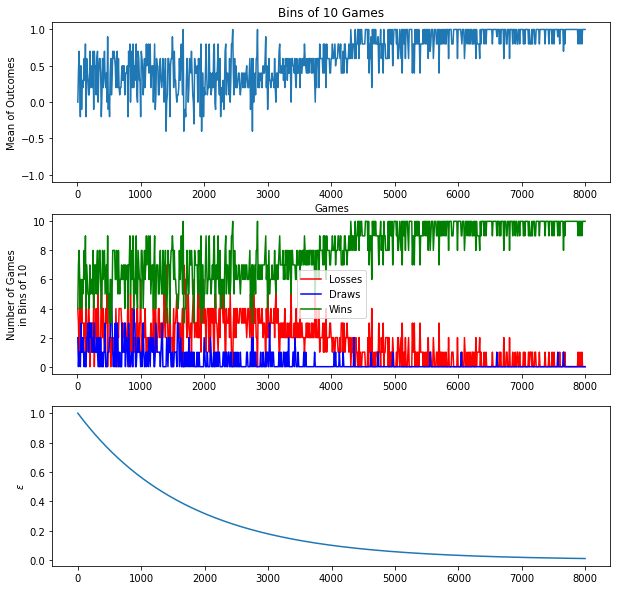

In [0]:
result, Qnets = run([[]], [[100, 20]], [40], [0.001], 1, True)

In [0]:
Qnets

{'O': NeuralNetwork(10, [100, 20], 1, 'tanh'),
 'X': NeuralNetwork(10, [], 1, 'tanh')}

In [0]:
print(Qnets['X'])
print(Qnets['O'])

NeuralNetwork(10, [], 1, 'tanh') trained for 40 epochs, final training error 0.0373
NeuralNetwork(10, [100, 20], 1, 'tanh') trained for 40 epochs, final training error 0.0004


Change the following function to compare different neural network structures for X and for O and also try multiple values for `n_epochs` and `learning_rate`.  Include the results of running your function in this notebook.

Try at least three different network structures for each player and three different values for `n_epochs` and three different values for `learning_rate`.  Use at least 5 for the second to last argument so your results are averaged over 5 repetitions. Try to find parameters for which O consistently wins, and ones for which X consistently wins. Include these choices in the lists of parameter values in the following function.

Discuss your results.  Do they make sense?

Here is an example run, though you must use at least three values for each of the first four arguments.

In [0]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [10, 10],[10,10,10],[20,10],[30,15,10]],
                        O_hidden_units_list_of_lists=[[], [100, 20], [20, 20, 20]],
                        n_epochs_list=[30,40,60],
                        learning_rate_list=[0.001,0.01,0.1], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result

Streaming output truncated to the last 5000 lines.
sgd: Epoch 12 Error=0.19063
sgd: Epoch 15 Error=0.18481
sgd: Epoch 18 Error=0.17977
sgd: Epoch 21 Error=0.17540
sgd: Epoch 24 Error=0.17163
sgd: Epoch 27 Error=0.16839
sgd: Epoch 30 Error=0.16559
sgd: Epoch 3 Error=0.35093
sgd: Epoch 6 Error=0.34618
sgd: Epoch 9 Error=0.34188
sgd: Epoch 12 Error=0.33800
sgd: Epoch 15 Error=0.33449
sgd: Epoch 18 Error=0.33133
sgd: Epoch 21 Error=0.32849
sgd: Epoch 24 Error=0.32593
sgd: Epoch 27 Error=0.32362
sgd: Epoch 30 Error=0.32155
sgd: Epoch 3 Error=0.36686
sgd: Epoch 6 Error=0.36551
sgd: Epoch 9 Error=0.36418
sgd: Epoch 12 Error=0.36286
sgd: Epoch 15 Error=0.36154
sgd: Epoch 18 Error=0.36024
sgd: Epoch 21 Error=0.35894
sgd: Epoch 24 Error=0.35765
sgd: Epoch 27 Error=0.35636
sgd: Epoch 30 Error=0.35509
sgd: Epoch 3 Error=0.21470
sgd: Epoch 6 Error=0.21021
sgd: Epoch 9 Error=0.20611
sgd: Epoch 12 Error=0.20238
sgd: Epoch 15 Error=0.19899
sgd: Epoch 18 Error=0.19591
sgd: Epoch 21 Error=0.19312
sgd: E

In [0]:
import time
start_time = time.time()


   
result1, Qnets1 = run(X_hidden_units_list_of_lists=[ [10, 10]], #,[30,15,10]
                    O_hidden_units_list_of_lists=[[20, 10]],  # [20, 20, 20]
                    n_epochs_list=[20],
                    learning_rate_list=[0.001], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result1

Streaming output truncated to the last 5000 lines.
sgd: Epoch 8 Error=0.18288
sgd: Epoch 10 Error=0.18185
sgd: Epoch 12 Error=0.18084
sgd: Epoch 14 Error=0.17984
sgd: Epoch 16 Error=0.17887
sgd: Epoch 18 Error=0.17792
sgd: Epoch 20 Error=0.17698
sgd: Epoch 2 Error=0.13640
sgd: Epoch 4 Error=0.13507
sgd: Epoch 6 Error=0.13378
sgd: Epoch 8 Error=0.13253
sgd: Epoch 10 Error=0.13131
sgd: Epoch 12 Error=0.13013
sgd: Epoch 14 Error=0.12899
sgd: Epoch 16 Error=0.12788
sgd: Epoch 18 Error=0.12680
sgd: Epoch 20 Error=0.12576
sgd: Epoch 2 Error=0.25528
sgd: Epoch 4 Error=0.25438
sgd: Epoch 6 Error=0.25350
sgd: Epoch 8 Error=0.25264
sgd: Epoch 10 Error=0.25180
sgd: Epoch 12 Error=0.25098
sgd: Epoch 14 Error=0.25017
sgd: Epoch 16 Error=0.24938
sgd: Epoch 18 Error=0.24861
sgd: Epoch 20 Error=0.24785
sgd: Epoch 2 Error=0.40934
sgd: Epoch 4 Error=0.40741
sgd: Epoch 6 Error=0.40553
sgd: Epoch 8 Error=0.40372
sgd: Epoch 10 Error=0.40195
sgd: Epoch 12 Error=0.40024
sgd: Epoch 14 Error=0.39859
sgd: Epoch

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[10, 10]","[20, 10]",20,0.001,0.838625


In [0]:
start_time = time.time()


   
result2, Qnets2 = run(X_hidden_units_list_of_lists=[[30,15,10]], #,[30,15,10]
                    O_hidden_units_list_of_lists=[[20, 20, 20]],  # [20, 20, 20]
                    n_epochs_list=[20,10],
                    learning_rate_list=[0.001,0.01], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')


Streaming output truncated to the last 5000 lines.
sgd: Epoch 10 Error=0.00047
sgd: Epoch 12 Error=0.00047
sgd: Epoch 14 Error=0.00047
sgd: Epoch 16 Error=0.00047
sgd: Epoch 18 Error=0.00047
sgd: Epoch 20 Error=0.00047
sgd: Epoch 2 Error=0.01586
sgd: Epoch 4 Error=0.01586
sgd: Epoch 6 Error=0.01585
sgd: Epoch 8 Error=0.01584
sgd: Epoch 10 Error=0.01584
sgd: Epoch 12 Error=0.01583
sgd: Epoch 14 Error=0.01582
sgd: Epoch 16 Error=0.01582
sgd: Epoch 18 Error=0.01581
sgd: Epoch 20 Error=0.01580
sgd: Epoch 2 Error=0.00047
sgd: Epoch 4 Error=0.00047
sgd: Epoch 6 Error=0.00047
sgd: Epoch 8 Error=0.00047
sgd: Epoch 10 Error=0.00047
sgd: Epoch 12 Error=0.00047
sgd: Epoch 14 Error=0.00047
sgd: Epoch 16 Error=0.00047
sgd: Epoch 18 Error=0.00047
sgd: Epoch 20 Error=0.00047
sgd: Epoch 2 Error=0.01577
sgd: Epoch 4 Error=0.01577
sgd: Epoch 6 Error=0.01576
sgd: Epoch 8 Error=0.01575
sgd: Epoch 10 Error=0.01574
sgd: Epoch 12 Error=0.01574
sgd: Epoch 14 Error=0.01573
sgd: Epoch 16 Error=0.01572
sgd: Epoc

In [0]:
result2

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[30, 15, 10]","[20, 20, 20]",20,0.001,0.859250
1,"[30, 15, 10]","[20, 20, 20]",20,0.010,0.887625
2,"[30, 15, 10]","[20, 20, 20]",10,0.001,0.945750
3,"[30, 15, 10]","[20, 20, 20]",10,0.010,0.957625


In [0]:
start_time = time.time()


   
result3, Qnets3 = run(X_hidden_units_list_of_lists=[[10]], 
                    O_hidden_units_list_of_lists=[[20, 10]], 
                    n_epochs_list=[20,10],
                    learning_rate_list=[0.001,0.01], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result3

Streaming output truncated to the last 5000 lines.
sgd: Epoch 4 Error=0.01492
sgd: Epoch 5 Error=0.01492
sgd: Epoch 6 Error=0.01491
sgd: Epoch 7 Error=0.01491
sgd: Epoch 8 Error=0.01491
sgd: Epoch 9 Error=0.01490
sgd: Epoch 10 Error=0.01490
sgd: Epoch 1 Error=0.00801
sgd: Epoch 2 Error=0.00800
sgd: Epoch 3 Error=0.00799
sgd: Epoch 4 Error=0.00798
sgd: Epoch 5 Error=0.00798
sgd: Epoch 6 Error=0.00797
sgd: Epoch 7 Error=0.00796
sgd: Epoch 8 Error=0.00795
sgd: Epoch 9 Error=0.00795
sgd: Epoch 10 Error=0.00794
sgd: Epoch 1 Error=0.01493
sgd: Epoch 2 Error=0.01493
sgd: Epoch 3 Error=0.01492
sgd: Epoch 4 Error=0.01492
sgd: Epoch 5 Error=0.01492
sgd: Epoch 6 Error=0.01491
sgd: Epoch 7 Error=0.01491
sgd: Epoch 8 Error=0.01491
sgd: Epoch 9 Error=0.01490
sgd: Epoch 10 Error=0.01490
sgd: Epoch 1 Error=0.00786
sgd: Epoch 2 Error=0.00785
sgd: Epoch 3 Error=0.00784
sgd: Epoch 4 Error=0.00783
sgd: Epoch 5 Error=0.00783
sgd: Epoch 6 Error=0.00782
sgd: Epoch 7 Error=0.00781
sgd: Epoch 8 Error=0.00781
s

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[10],"[20, 10]",20,0.001,0.851750
1,[10],"[20, 10]",20,0.010,0.750125
2,[10],"[20, 10]",10,0.001,0.831625
3,[10],"[20, 10]",10,0.010,0.951875


In [0]:
start_time = time.time()


   
result4, Qnets4 = run(X_hidden_units_list_of_lists=[[5]], 
                    O_hidden_units_list_of_lists=[[40, 60]], 
                    n_epochs_list=[20,10],
                    learning_rate_list=[0.001,0.01], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result4

Streaming output truncated to the last 5000 lines.
sgd: Epoch 4 Error=0.09733
sgd: Epoch 5 Error=0.09569
sgd: Epoch 6 Error=0.09413
sgd: Epoch 7 Error=0.09265
sgd: Epoch 8 Error=0.09124
sgd: Epoch 9 Error=0.08990
sgd: Epoch 10 Error=0.08862
sgd: Epoch 1 Error=0.35714
sgd: Epoch 2 Error=0.27007
sgd: Epoch 3 Error=0.24997
sgd: Epoch 4 Error=0.24591
sgd: Epoch 5 Error=0.24510
sgd: Epoch 6 Error=0.24492
sgd: Epoch 7 Error=0.24486
sgd: Epoch 8 Error=0.24482
sgd: Epoch 9 Error=0.24479
sgd: Epoch 10 Error=0.24476
sgd: Epoch 1 Error=0.14274
sgd: Epoch 2 Error=0.14093
sgd: Epoch 3 Error=0.13921
sgd: Epoch 4 Error=0.13756
sgd: Epoch 5 Error=0.13600
sgd: Epoch 6 Error=0.13450
sgd: Epoch 7 Error=0.13307
sgd: Epoch 8 Error=0.13171
sgd: Epoch 9 Error=0.13040
sgd: Epoch 10 Error=0.12915
sgd: Epoch 1 Error=0.18527
sgd: Epoch 2 Error=0.14379
sgd: Epoch 3 Error=0.13397
sgd: Epoch 4 Error=0.13191
sgd: Epoch 5 Error=0.13149
sgd: Epoch 6 Error=0.13139
sgd: Epoch 7 Error=0.13136
sgd: Epoch 8 Error=0.13135
s

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[5],"[40, 60]",20,0.001,0.784625
1,[5],"[40, 60]",20,0.010,0.934500
2,[5],"[40, 60]",10,0.001,0.803125
3,[5],"[40, 60]",10,0.010,0.969750


In [0]:
start_time = time.time()


   
result5, Qnets5 = run(X_hidden_units_list_of_lists=[[]], 
                    O_hidden_units_list_of_lists=[[]], 
                    n_epochs_list=[20,10],
                    learning_rate_list=[0.001,0.01], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result5

Streaming output truncated to the last 5000 lines.
sgd: Epoch 4 Error=0.00575
sgd: Epoch 5 Error=0.00574
sgd: Epoch 6 Error=0.00573
sgd: Epoch 7 Error=0.00572
sgd: Epoch 8 Error=0.00571
sgd: Epoch 9 Error=0.00570
sgd: Epoch 10 Error=0.00569
sgd: Epoch 1 Error=0.00000
sgd: Epoch 2 Error=0.00000
sgd: Epoch 3 Error=0.00000
sgd: Epoch 4 Error=0.00000
sgd: Epoch 5 Error=0.00000
sgd: Epoch 6 Error=0.00000
sgd: Epoch 7 Error=0.00000
sgd: Epoch 8 Error=0.00000
sgd: Epoch 9 Error=0.00000
sgd: Epoch 10 Error=0.00000
sgd: Epoch 1 Error=0.00564
sgd: Epoch 2 Error=0.00563
sgd: Epoch 3 Error=0.00562
sgd: Epoch 4 Error=0.00561
sgd: Epoch 5 Error=0.00560
sgd: Epoch 6 Error=0.00559
sgd: Epoch 7 Error=0.00558
sgd: Epoch 8 Error=0.00557
sgd: Epoch 9 Error=0.00556
sgd: Epoch 10 Error=0.00555
sgd: Epoch 1 Error=0.00000
sgd: Epoch 2 Error=0.00000
sgd: Epoch 3 Error=0.00000
sgd: Epoch 4 Error=0.00000
sgd: Epoch 5 Error=0.00000
sgd: Epoch 6 Error=0.00000
sgd: Epoch 7 Error=0.00000
sgd: Epoch 8 Error=0.00000
s

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],[],20,0.001,0.933375
1,[],[],20,0.010,0.943750
2,[],[],10,0.001,0.936125
3,[],[],10,0.010,0.935500


In [0]:
start_time = time.time()


   
result6, Qnets6 = run(X_hidden_units_list_of_lists=[[]], 
                    O_hidden_units_list_of_lists=[[50,50]], 
                    n_epochs_list=[100],
                    learning_rate_list=[0.0001], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result6

Streaming output truncated to the last 5000 lines.
sgd: Epoch 40 Error=0.25822
sgd: Epoch 50 Error=0.25812
sgd: Epoch 60 Error=0.25803
sgd: Epoch 70 Error=0.25793
sgd: Epoch 80 Error=0.25783
sgd: Epoch 90 Error=0.25774
sgd: Epoch 100 Error=0.25764
sgd: Epoch 10 Error=0.20950
sgd: Epoch 20 Error=0.20463
sgd: Epoch 30 Error=0.20012
sgd: Epoch 40 Error=0.19596
sgd: Epoch 50 Error=0.19212
sgd: Epoch 60 Error=0.18858
sgd: Epoch 70 Error=0.18532
sgd: Epoch 80 Error=0.18233
sgd: Epoch 90 Error=0.17958
sgd: Epoch 100 Error=0.17705
sgd: Epoch 10 Error=0.25795
sgd: Epoch 20 Error=0.25786
sgd: Epoch 30 Error=0.25776
sgd: Epoch 40 Error=0.25766
sgd: Epoch 50 Error=0.25757
sgd: Epoch 60 Error=0.25747
sgd: Epoch 70 Error=0.25737
sgd: Epoch 80 Error=0.25728
sgd: Epoch 90 Error=0.25718
sgd: Epoch 100 Error=0.25709
sgd: Epoch 10 Error=0.16796
sgd: Epoch 20 Error=0.16405
sgd: Epoch 30 Error=0.16044
sgd: Epoch 40 Error=0.15710
sgd: Epoch 50 Error=0.15402
sgd: Epoch 60 Error=0.15118
sgd: Epoch 70 Error=0.

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[50, 50]",100,0.0001,0.395875


In [56]:
start_time = time.time()


   
result7, Qnets7 = run(X_hidden_units_list_of_lists=[[]], 
                    O_hidden_units_list_of_lists=[[20,40]], 
                    n_epochs_list=[100],
                    learning_rate_list=[0.1], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result7

1 sgd: Epoch 10 Error=5.42803
sgd: Epoch 20 Error=336.87361
sgd: Epoch 30 Error=20983.07690
sgd: Epoch 40 Error=1306988.07048
sgd: Epoch 50 Error=81409310.22412
sgd: Epoch 60 Error=5070800522.85917
sgd: Epoch 70 Error=315848615739.88684
sgd: Epoch 80 Error=19673490924181.09375
sgd: Epoch 90 Error=1225416942978098.00000
sgd: Epoch 100 Error=76328430471486960.00000
sgd: Epoch 10 Error=1.65641
sgd: Epoch 20 Error=1.06127
sgd: Epoch 30 Error=1.11956
sgd: Epoch 40 Error=0.57404
sgd: Epoch 50 Error=2.17963
sgd: Epoch 60 Error=0.58196
sgd: Epoch 70 Error=2.08783
sgd: Epoch 80 Error=0.24717
sgd: Epoch 90 Error=0.39635
sgd: Epoch 100 Error=0.18594
sgd: Epoch 10 Error=998481164581089968128.00000
sgd: Epoch 20 Error=43867410954176861841653760.00000
sgd: Epoch 30 Error=1927276963325761147851230937088.00000
sgd: Epoch 40 Error=84673255443458048191731005311156224.00000
sgd: Epoch 50 Error=3720046637729286210015003628460511854592.00000
sgd: Epoch 60 Error=163437048858030576551035663113379117996703744

/content/neuralnetwork_regression.py:158: RuntimeWarning: overflow encountered in square
  mean_sq_error = np.mean((T - Ys[-1]) ** 2)
/content/neuralnetwork_regression.py:179: RuntimeWarning: overflow encountered in multiply
  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
/content/neuralnetwork_regression.py:179: RuntimeWarning: overflow encountered in matmul
  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
/content/neuralnetwork_regression.py:179: RuntimeWarning: invalid value encountered in multiply
  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)


sgd: Epoch 70 Error=0.72433
sgd: Epoch 80 Error=0.71865
sgd: Epoch 90 Error=0.70912
sgd: Epoch 100 Error=0.68893
sgd: Epoch 10 Error=inf
sgd: Epoch 20 Error=inf
sgd: Epoch 30 Error=inf
sgd: Epoch 40 Error=inf
sgd: Epoch 50 Error=inf
sgd: Epoch 60 Error=inf
sgd: Epoch 70 Error=inf
sgd: Epoch 80 Error=inf
sgd: Epoch 90 Error=inf
sgd: Epoch 100 Error=inf
sgd: Epoch 10 Error=0.27178
sgd: Epoch 20 Error=0.26409
sgd: Epoch 30 Error=0.25823
sgd: Epoch 40 Error=0.25147
sgd: Epoch 50 Error=0.24413
sgd: Epoch 60 Error=0.23701
sgd: Epoch 70 Error=0.23081
sgd: Epoch 80 Error=0.22569
sgd: Epoch 90 Error=0.22142
sgd: Epoch 100 Error=0.21772
sgd: Epoch 10 Error=inf
sgd: Epoch 20 Error=inf
sgd: Epoch 30 Error=inf
sgd: Epoch 40 Error=inf
sgd: Epoch 50 Error=inf
sgd: Epoch 60 Error=inf
sgd: Epoch 70 Error=inf
sgd: Epoch 80 Error=inf
sgd: Epoch 90 Error=inf
sgd: Epoch 100 Error=inf
sgd: Epoch 10 Error=0.90437
sgd: Epoch 20 Error=0.78393
sgd: Epoch 30 Error=0.97338
sgd: Epoch 40 Error=0.95104
sgd: Epoch 5

/content/neuralnetwork_regression.py:172: RuntimeWarning: overflow encountered in matmul
  self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
/content/neuralnetwork_regression.py:172: RuntimeWarning: invalid value encountered in matmul
  self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
/content/optimizers.py:42: RuntimeWarning: invalid value encountered in subtract
  self.all_weights -= learning_rate * grad


Streaming output truncated to the last 5000 lines.
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=0.07814
sgd: Epoch 20 Error=0.02936
sgd: Epoch 30 Error=0.01089
sgd: Epoch 40 Error=0.00403
sgd: Epoch 50 Error=0.00149
sgd: Epoch 60 Error=0.00055
sgd: Epoch 70 Error=0.00020
sgd: Epoch 80 Error=0.00008
sgd: Epoch 90 Error=0.00003
sgd: Epoch 100 Error=0.00001
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=0.09035
sgd: Epoch 20 Error=0.02725
sgd: Epoch 30 Err

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Streaming output truncated to the last 5000 lines.
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoc

/content/neuralnetwork_regression.py:152: RuntimeWarning: invalid value encountered in matmul
  self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])


Streaming output truncated to the last 5000 lines.
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoch 30 Error=nan
sgd: Epoch 40 Error=nan
sgd: Epoch 50 Error=nan
sgd: Epoch 60 Error=nan
sgd: Epoch 70 Error=nan
sgd: Epoch 80 Error=nan
sgd: Epoch 90 Error=nan
sgd: Epoch 100 Error=nan
sgd: Epoch 10 Error=nan
sgd: Epoch 20 Error=nan
sgd: Epoc

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[20, 40]",100,0.1,0.279125


In [58]:
start_time = time.time()


   
result8, Qnets8 = run(X_hidden_units_list_of_lists=[[20,40,60]], 
                    O_hidden_units_list_of_lists=[[25,40]], 
                    n_epochs_list=[80],
                    learning_rate_list=[0.001], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result8

Streaming output truncated to the last 5000 lines.
sgd: Epoch 32 Error=0.65020
sgd: Epoch 40 Error=0.64873
sgd: Epoch 48 Error=0.64818
sgd: Epoch 56 Error=0.64798
sgd: Epoch 64 Error=0.64790
sgd: Epoch 72 Error=0.64787
sgd: Epoch 80 Error=0.64786
sgd: Epoch 8 Error=0.48072
sgd: Epoch 16 Error=0.44508
sgd: Epoch 24 Error=0.41930
sgd: Epoch 32 Error=0.40040
sgd: Epoch 40 Error=0.38639
sgd: Epoch 48 Error=0.37590
sgd: Epoch 56 Error=0.36797
sgd: Epoch 64 Error=0.36195
sgd: Epoch 72 Error=0.35734
sgd: Epoch 80 Error=0.35379
sgd: Epoch 8 Error=0.45244
sgd: Epoch 16 Error=0.42726
sgd: Epoch 24 Error=0.41754
sgd: Epoch 32 Error=0.41388
sgd: Epoch 40 Error=0.41251
sgd: Epoch 48 Error=0.41200
sgd: Epoch 56 Error=0.41181
sgd: Epoch 64 Error=0.41174
sgd: Epoch 72 Error=0.41172
sgd: Epoch 80 Error=0.41171
sgd: Epoch 8 Error=0.54572
sgd: Epoch 16 Error=0.39896
sgd: Epoch 24 Error=0.31469
sgd: Epoch 32 Error=0.26363
sgd: Epoch 40 Error=0.23007
sgd: Epoch 48 Error=0.20581
sgd: Epoch 56 Error=0.18670


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[20, 40, 60]","[25, 40]",80,0.001,-0.2595


In [59]:
start_time = time.time()


   
result9, Qnets9 = run(X_hidden_units_list_of_lists=[[20,40,60]], 
                    O_hidden_units_list_of_lists=[[50,100]], 
                    n_epochs_list=[80],
                    learning_rate_list=[0.001], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result9

Streaming output truncated to the last 5000 lines.
sgd: Epoch 32 Error=0.03524
sgd: Epoch 40 Error=0.03510
sgd: Epoch 48 Error=0.03497
sgd: Epoch 56 Error=0.03483
sgd: Epoch 64 Error=0.03470
sgd: Epoch 72 Error=0.03456
sgd: Epoch 80 Error=0.03443
sgd: Epoch 8 Error=0.00039
sgd: Epoch 16 Error=0.00032
sgd: Epoch 24 Error=0.00029
sgd: Epoch 32 Error=0.00027
sgd: Epoch 40 Error=0.00026
sgd: Epoch 48 Error=0.00026
sgd: Epoch 56 Error=0.00026
sgd: Epoch 64 Error=0.00026
sgd: Epoch 72 Error=0.00026
sgd: Epoch 80 Error=0.00026
sgd: Epoch 8 Error=0.03480
sgd: Epoch 16 Error=0.03466
sgd: Epoch 24 Error=0.03453
sgd: Epoch 32 Error=0.03439
sgd: Epoch 40 Error=0.03426
sgd: Epoch 48 Error=0.03412
sgd: Epoch 56 Error=0.03399
sgd: Epoch 64 Error=0.03386
sgd: Epoch 72 Error=0.03372
sgd: Epoch 80 Error=0.03359
sgd: Epoch 8 Error=0.00040
sgd: Epoch 16 Error=0.00037
sgd: Epoch 24 Error=0.00036
sgd: Epoch 32 Error=0.00035
sgd: Epoch 40 Error=0.00035
sgd: Epoch 48 Error=0.00035
sgd: Epoch 56 Error=0.00035


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[50, 50, 50]",80,0.001,0.932625


In [61]:
start_time = time.time()


   
result10, Qnets10 = run(X_hidden_units_list_of_lists=[[20,40,60]], 
                    O_hidden_units_list_of_lists=[[50,100]], 
                    n_epochs_list=[80],
                    learning_rate_list=[0.001], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result10

Streaming output truncated to the last 5000 lines.
sgd: Epoch 32 Error=0.00076
sgd: Epoch 40 Error=0.00076
sgd: Epoch 48 Error=0.00076
sgd: Epoch 56 Error=0.00076
sgd: Epoch 64 Error=0.00076
sgd: Epoch 72 Error=0.00076
sgd: Epoch 80 Error=0.00076
sgd: Epoch 8 Error=0.00282
sgd: Epoch 16 Error=0.00282
sgd: Epoch 24 Error=0.00282
sgd: Epoch 32 Error=0.00282
sgd: Epoch 40 Error=0.00282
sgd: Epoch 48 Error=0.00281
sgd: Epoch 56 Error=0.00281
sgd: Epoch 64 Error=0.00281
sgd: Epoch 72 Error=0.00281
sgd: Epoch 80 Error=0.00281
sgd: Epoch 8 Error=0.00076
sgd: Epoch 16 Error=0.00076
sgd: Epoch 24 Error=0.00076
sgd: Epoch 32 Error=0.00076
sgd: Epoch 40 Error=0.00076
sgd: Epoch 48 Error=0.00076
sgd: Epoch 56 Error=0.00076
sgd: Epoch 64 Error=0.00076
sgd: Epoch 72 Error=0.00076
sgd: Epoch 80 Error=0.00076
sgd: Epoch 8 Error=0.00279
sgd: Epoch 16 Error=0.00279
sgd: Epoch 24 Error=0.00279
sgd: Epoch 32 Error=0.00278
sgd: Epoch 40 Error=0.00278
sgd: Epoch 48 Error=0.00278
sgd: Epoch 56 Error=0.00278


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[20, 40, 60]","[50, 100]",80,0.001,0.890125


In [80]:
final = pandas.DataFrame()
final = final.append(result10, ignore_index=True)
final = final.append(result9, ignore_index=True)
final = final.append(result8, ignore_index=True)
final = final.append(result7, ignore_index=True)
final = final.append(result6, ignore_index=True)

final

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[20, 40, 60]","[50, 100]",80,0.0010,0.890125
1,[],"[50, 50, 50]",80,0.0010,0.932625
2,"[20, 40, 60]","[25, 40]",80,0.0010,-0.259500
3,[],"[20, 40]",100,0.1000,0.279125
4,[],"[50, 50]",100,0.0001,0.395875


# Observations

|S.No|X_nh |	O_nh|	n_epochs|	lr|last_fifth_outcomes|
|----|-----|-----|-----------|-----|-------------------|
|0|[10, 10]	|[20, 10]|	20	|0.001|	0.838625
|1|[30, 15, 10]|	[20, 20, 20]|	20	|0.001|	0.859250|
|2|[30, 15, 10]|	[20, 20, 20]|	20	|0.010| 0.887625|
|3|[30, 15, 10]|	[20, 20, 20]|	10	|0.001|	0.945750|
|4|[30, 15, 10]|	[20, 20, 20]|	10	|0.001|	0.945750|
|5|[30, 15, 10]|	[20, 20, 20]|	10	|0.010|	0.957625|
|6|[10]|	[20, 10]|	20	|0.001|	0.851750|
|7|[10]|	[20, 10]|	20	|0.010|	0.750125|
|8|[10]	|[20, 10]|	10	|0.001|	0.831625|
|9|[10]|	[20, 10]|	10	|0.010|	0.951875|
|10|[5]|	[40, 60]|20	|0.001	|0.784625|
|11|[5]|	[40, 60]|	10|	0.001|	0.803125|
|12|[5]|	[40, 60]|	10|	0.010|	0.969750|
|13|[]|	[]|	20|	0.001|	0.933375|
|14|[]|	[]|	20|	0.010|	0.943750|
|15|[]|	[]|	10|	0.001|	0.936125|
|16|[]|	[]|	10|	0.010|	0.935500|
|17|[]|	[50, 50]|	100|	0.0001|	0.395875|
|18|[]|	[20, 40]|	100	|0.1|	0.279125|
|19|[20, 40, 60]|	[25, 40]|	80|	0.001	|-0.2595
|20|[]	|[50, 50, 50]	|80	|0.001	|0.932625|
|21|[20, 40, 60]|	[50, 100]	|80|	0.001|	0.890125|


We can observe from the above table that we have a lot of cases where X has won and I was able to just get one case where we had O to win for the below configuration:

**X Network:**	[20 40 60]	

**O Network:** [25, 40]

**epochs:** 80

**learning rate:**	0.001

**Outcome:**	-0.2595

in this configuration we see inspite of having deeper network for X we still had O trained well and had a lot of wins overall.

The Configuration where X had number of more wins is:

**X Network:**	[5]	

**O Network:** [40, 60]

**epochs:**	10

**learning rate:**	0.010

**Outcome:**	0.969750


X has a large advantage as it always starting of first and is learning faster than O could. the reason for having more of positive values than negative values is that X is learning and optimizin to win while O seems to be learning and optimizing to get a draw. as we know for a draw we have a 0 and if X win we have a 1. so eventually the average tends to stay over 0 even for good trained Q net. That means even if we have a perfectly trained O network it would still be optimized to either win or atleast get to a draw. hence our values are always above 0 and rarely negative.

Due to memory constraints I couldnt run more combinations to check various architectures where O would win.

## Extra Credit

For 1 point of extra credit do the following steps.

1. Call `run` using your best parameter values and for 1 repetition.
2. Create four boards for which it is `X`'s turn. Using the returned `Qnets` print a display of the Q values generated by `Qnets['X']` in a 3 x 3 table corresponding to the tic tac toe board, for each of these four boards.
3. Create four boards for which it is `O`'s turn. Using the returned `Qnets` print a display of the Q values generated by `Qnets['O']` in a 3 x 3 table corresponding to the tic tac toe board, for these four boards.
4. Discuss the values.  Do they make sense?

In [60]:
start_time = time.time()


   
result_e, Qnets1_e = run(X_hidden_units_list_of_lists=[[5]], 
                    O_hidden_units_list_of_lists=[[40,60,50]], 
                    n_epochs_list=[20],
                    learning_rate_list=[0.01], 
                    repetitions=5, graphics=False)
   
print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')
result_e

Streaming output truncated to the last 5000 lines.
sgd: Epoch 8 Error=0.00009
sgd: Epoch 10 Error=0.00009
sgd: Epoch 12 Error=0.00008
sgd: Epoch 14 Error=0.00008
sgd: Epoch 16 Error=0.00008
sgd: Epoch 18 Error=0.00008
sgd: Epoch 20 Error=0.00008
sgd: Epoch 2 Error=0.00001
sgd: Epoch 4 Error=0.00001
sgd: Epoch 6 Error=0.00001
sgd: Epoch 8 Error=0.00001
sgd: Epoch 10 Error=0.00001
sgd: Epoch 12 Error=0.00001
sgd: Epoch 14 Error=0.00001
sgd: Epoch 16 Error=0.00001
sgd: Epoch 18 Error=0.00001
sgd: Epoch 20 Error=0.00001
sgd: Epoch 2 Error=0.00008
sgd: Epoch 4 Error=0.00008
sgd: Epoch 6 Error=0.00008
sgd: Epoch 8 Error=0.00008
sgd: Epoch 10 Error=0.00008
sgd: Epoch 12 Error=0.00008
sgd: Epoch 14 Error=0.00007
sgd: Epoch 16 Error=0.00007
sgd: Epoch 18 Error=0.00007
sgd: Epoch 20 Error=0.00007
sgd: Epoch 2 Error=0.00001
sgd: Epoch 4 Error=0.00001
sgd: Epoch 6 Error=0.00001
sgd: Epoch 8 Error=0.00001
sgd: Epoch 10 Error=0.00001
sgd: Epoch 12 Error=0.00001
sgd: Epoch 14 Error=0.00001
sgd: Epoch

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[5],"[40, 60, 50]",20,0.01,0.93825


In [0]:
QX = Qnets1_e['X']
QO = Qnets1_e['O']



In [0]:
def printBoard(board):
    print('''
{}|{}|{}
-----
{}|{}|{}
------
{}|{}|{}'''.format(*tuple(board)))

In [0]:
def printBoardQs(board,Q):
    printBoard(board)
    Qs = [Q.get((tuple(board),m), 0) for m in range(9)]
    print()
    print('''{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}
------------------
{:.2f} | {:.2f} | {:.2f}'''.format(*Qs))

In [93]:
board = np.array([' ']*9)
board[0] = 'X'
board[1] = 'O'
printBoardQs(board,QX)


X|O| 
-----
 | | 
------
 | | 


AttributeError: ignored

In [85]:
board1 =  np.array([0] * 9)
board2 = np.array(['O',' ','O', ' ','X','O', 'X',' ',' '])
board3 = np.array(['O',' ','O', ' ','X','O', 'X',' ',' '])
board4 = np.array(['X',' ','O', ' ','X','X', 'X',' ',' '])
printBoard(board1),printBoard(board2),printBoard(board3),printBoard(board4),


0|0|0
-----
0|0|0
------
0|0|0

O| |O
-----
 |X|O
------
X| | 

O| |O
-----
 |X|O
------
X| | 

X| |O
-----
 |X|X
------
X| | 


(None, None, None, None)

In [89]:
QX.use(board1)


ValueError: ignored

In [1]:
QX.all_weights

NameError: ignored

In [0]:
Samples = {'X': {'SA': [], 'R': [], 'Qn': []},
               'O': {'SA': [], 'R': [], 'Qn': []}}


Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:, :])
Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])
